#### Importing all the required **Python** and **R** libraries 

In [1]:
import os
import pathlib
import json
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import scarches as sca
warnings.filterwarnings("ignore")
import anndata as ad

import decoupler as dc

import sys
sys.path.append('../scripts')
from scarches.models import SCVI, SCANVI

%load_ext autoreload
%autoreload 2
#%load_ext lab_black

/home/daniele/miniconda3/envs/scmouse_atlas/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [2]:
sc.set_figure_params(frameon=False)
sc.settings.figdir = '/home/daniele/Code/scmouse_atlas/reports/figures/'

#### Read and concatenate

In [2]:
adata = sc.read_h5ad('/mnt/storage/Daniele/atlases/mouse/09_mouse_public_qced.h5ad')

In [ ]:
adata.write_h5ad('/mnt/storage/Daniele/atlases/mouse/09_mouse_public_qced.h5ad')

In [3]:
for key in adata.obs.columns:
    adata.obs[key] = adata.obs[key].astype(str).astype('category')

In [5]:
manual_genes_human = pd.read_csv('../../../supplementary_data/human/human_manual_genes.csv')

In [6]:
manual_genes_human.columns = ['genesymbol','manual']
manual_genes_human['pathway'] = '_' #dummy for decoupler
manual_genes_human = manual_genes_human[manual_genes_human['manual']]

In [7]:
mouse_manual_genes = dc.translate_net(manual_genes_human, target_organism='mouse')

In [8]:
man_genes = list(set(mouse_manual_genes['genesymbol'].values).intersection(adata.var_names))

In [9]:
adata_man_genes = adata[:, man_genes].copy()

#### SCVI

In [15]:
SCVI.setup_anndata(adata_man_genes, batch_key='donor_id')
vae=SCVI(adata_man_genes)

In [16]:
vae.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 104/104: 100%|██████████| 104/104 [09:44<00:00,  5.54s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.54e+3]

INFO: `Trainer.fit` stopped: `max_epochs=104` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=104` reached.


Epoch 104/104: 100%|██████████| 104/104 [09:44<00:00,  5.62s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.54e+3]


In [17]:
adata_man_genes.obsm['X_scVI'] = vae.get_latent_representation()
adata.obsm['X_scVI'] = adata_man_genes.obsm['X_scVI']

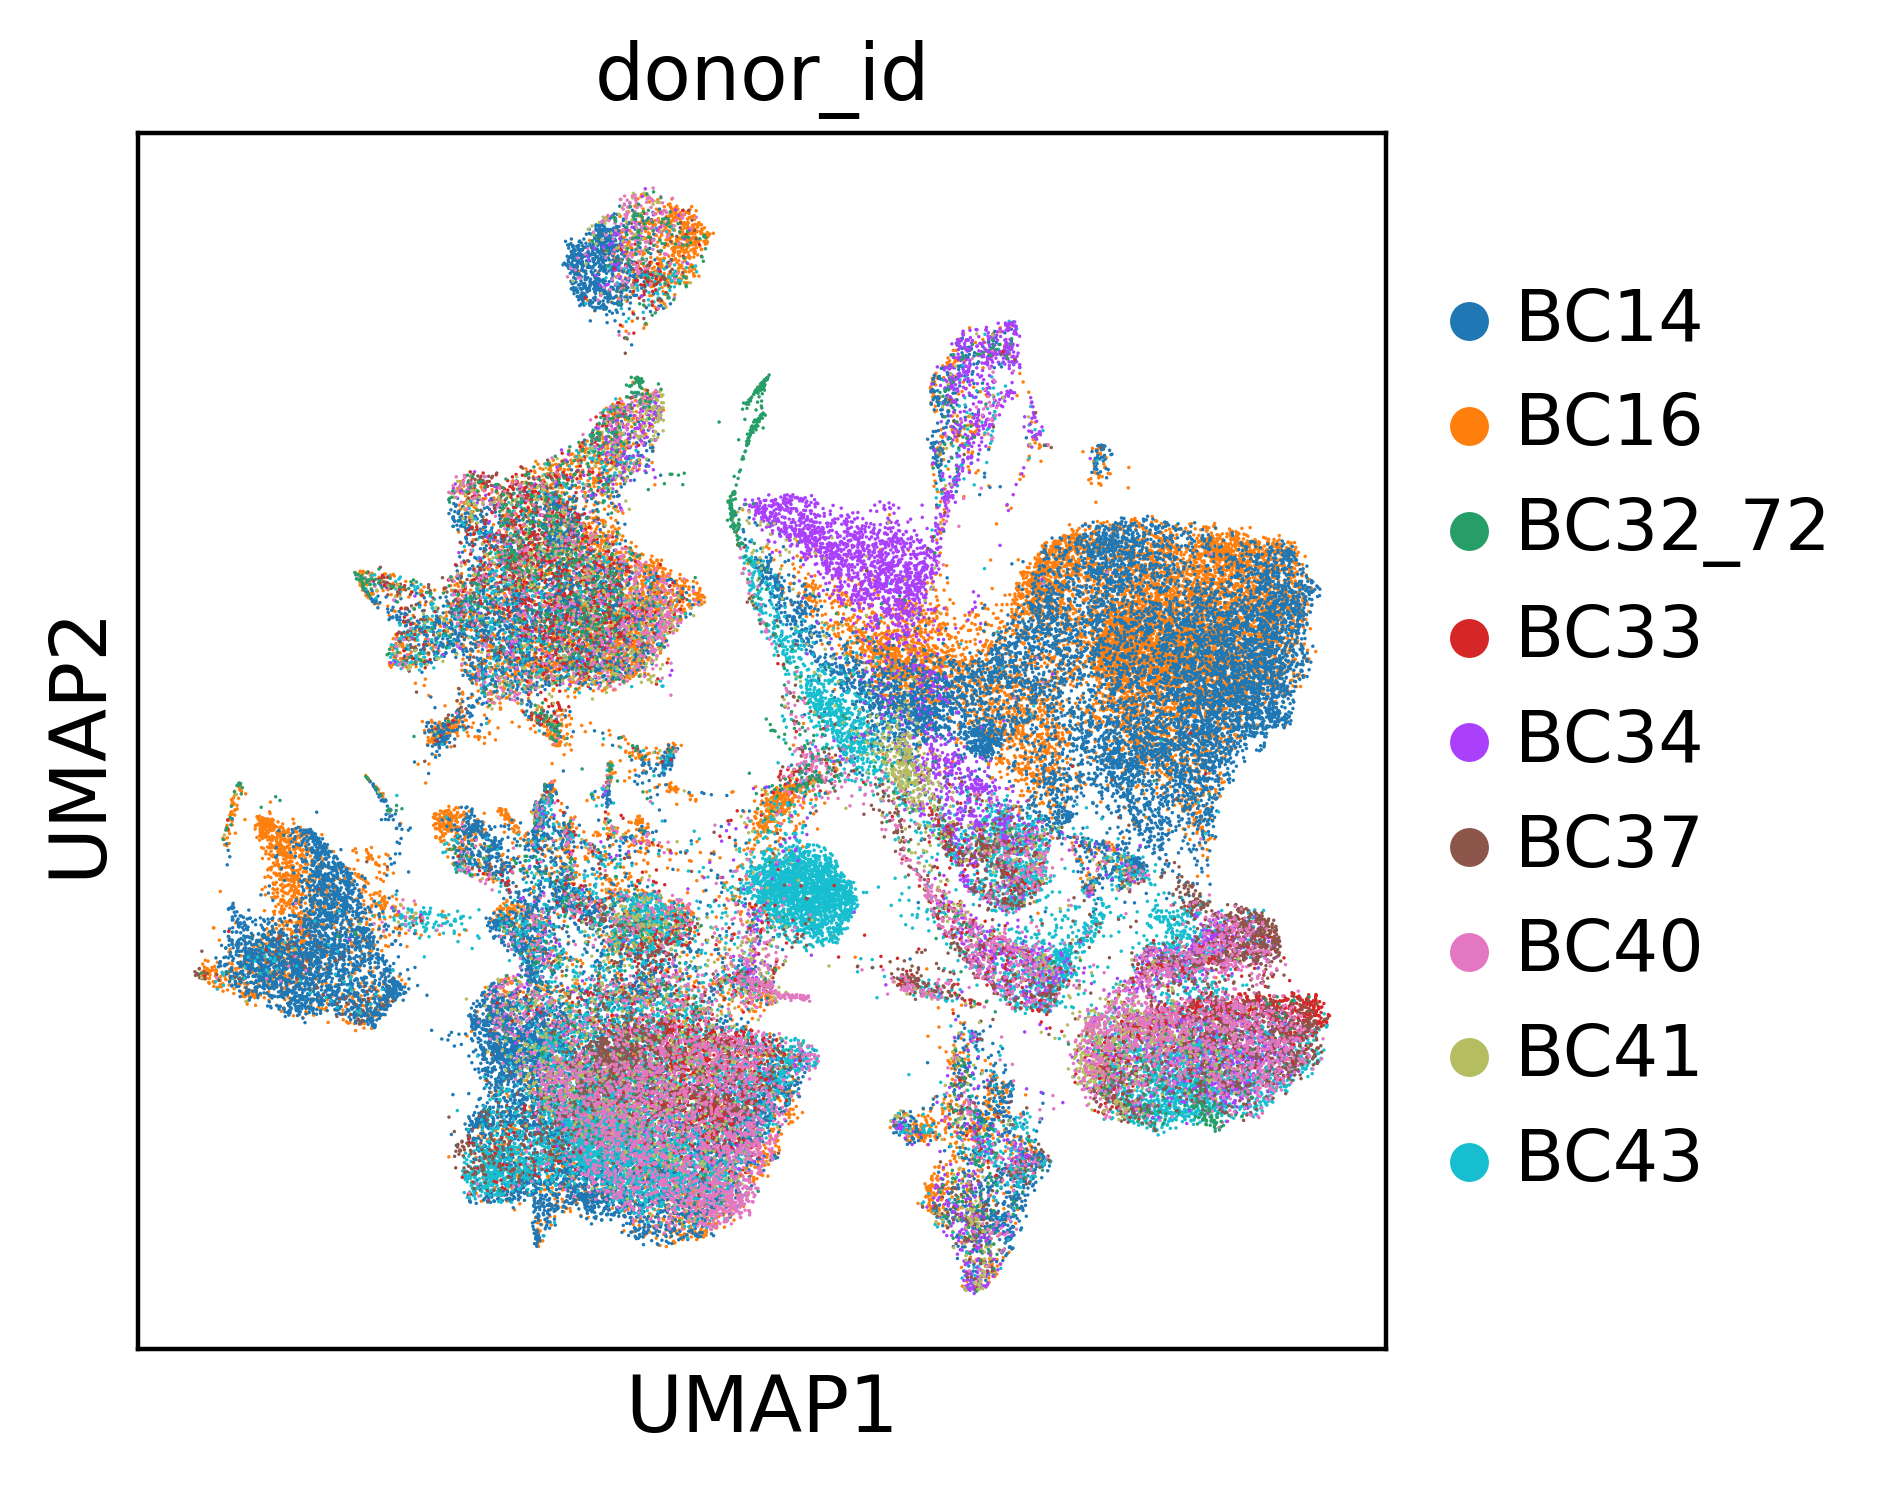

In [19]:
sc.pp.neighbors(adata, use_rep='X_scVI', n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color='donor_id')

In [20]:
adata.write_h5ad('/mnt/storage/Daniele/atlases/mouse/02_mouse_larry_barcoded_integrated_scvi.h5ad')